# Principal Component Analysis

So far, we have worked with relatively small datasets, with a limited set of interpretable variables. We have seen how models such as linear and logistic regression can help in understanding and interpreting the relationships between variables.

In practice, in many cases, we will work with larger sets of data, where individual variables are not always interpretable. **Consider for instance a dataset of medical images with a resolution of $600 \times 600$ pixels. We may want to be able to apply data analysis to such images, for instance, for automated diagnosis, but, if we think about it, we obtain a set of $360000$ individual columns. Moreover, such columns are not directly interpretable (each one represent the gray value of a specific pixel in the image).**

In most of these cases, **the data will be highly redundant, with different variables being dependent or reporting similar data in different forms**. Think about it: if there is a large number of variables, it is more likely that some of them capture the same phenomenon from different points of view.


## Feature Selection vs Feature Reduction
We have seen how, when many variables are available, it makes sense to select a subset of such variables. In regression analysis, in particular, we have seen how, when features are highly correlated, we should **discard some of them to reduce collinearity**. Indeed, if two variables $x$ and $y$ are highly correlated, one of the two is redundant to a given extent, and we can ignore it.

We have seen how variables can be selected in different ways:
* By looking at the correlation matrix, we can directly find those pairs of variables which are highly correlated;
* When defining a linear or logistic regressor, we can remove those variables with a high p-value. We have seen that these are variables which do not contribute significantly to the prediction of the dependent variable, given all other variables present in the regressor;
* Techniques such as **Ridge and Lasso regression** allow to perform some form of variable (or feature) selection, setting very low or zero coefficients for variables which do not contribute significantly to regression.

**In general, however, when we discard a set of variables, we throw away some informative content, unless the variables we are removing can be perfectly reconstructed from the variables we are keeping, e.g., because they are linear combinations of other variables.**

Instead of selecting a subset of features to work with, **feature reduction techniques** aim to **find a new set of features which summarize the original set of features losing a small amount of information, while maintaining a limited number of dimensions**.

## Feature Reduction Example
Let us consider the Iris dataset. In particular, we will consider two features: `sepal length` and `petal length`:

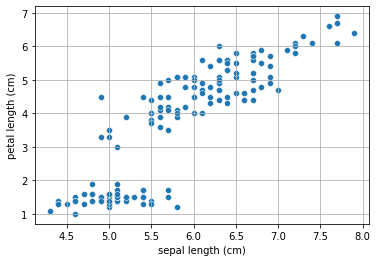

In [64]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
import seaborn as sns

data = load_iris(as_frame=True)['data']
sns.scatterplot(x='sepal length (cm)', y='petal length (cm)', data=data)
plt.grid()
plt.show()

We can see from the plot above that the two features are highly correlated. Let us compute the Pearson coefficient and the related p-value:

In [66]:
from scipy.stats import pearsonr
pearsonr(data['petal length (cm)'], data['sepal length (cm)'])

PearsonRResult(statistic=0.8717537758865831, pvalue=1.0386674194498827e-47)

Let's say we want to reduce the number of features (e.g., for computational reasons). We could think of applying **feature selection** and choose one fo the two, but we would surely **loose some information**. Instead, we could think of a **linear projection of the data into a single dimension** such that we loose the least possible amount of information.

To avoid any dependence on the units of measures and on the positioning of the points in the space, let's first standardize the data:

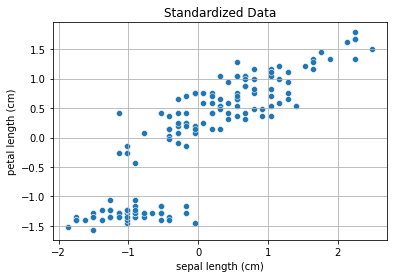

In [3]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Load the dataset
data = load_iris(as_frame=True)['data']

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

# Convert the standardized data back to a DataFrame
standardized_data = pd.DataFrame(standardized_data, columns=data.columns)

# Plot the standardized data
sns.scatterplot(x='sepal length (cm)', y='petal length (cm)', data=standardized_data)
plt.grid()
plt.title('Standardized Data')
plt.show()


Transforming the 2D data to a single dimension with a linear transformation can be done with the following expression:

$$z = u_1 x_1 + u_2 x_2$$

Note that this is equivalent to projecting point $(x_1,x_y)$ to the line passing from the origin with the following equation:

$$y = \frac{u_2}{u_1}x$$

Once we choose a set of $(u_1,u_2)$, we obtain a different projection, as in the example below, where we project the data to different random lines passing through the origin:

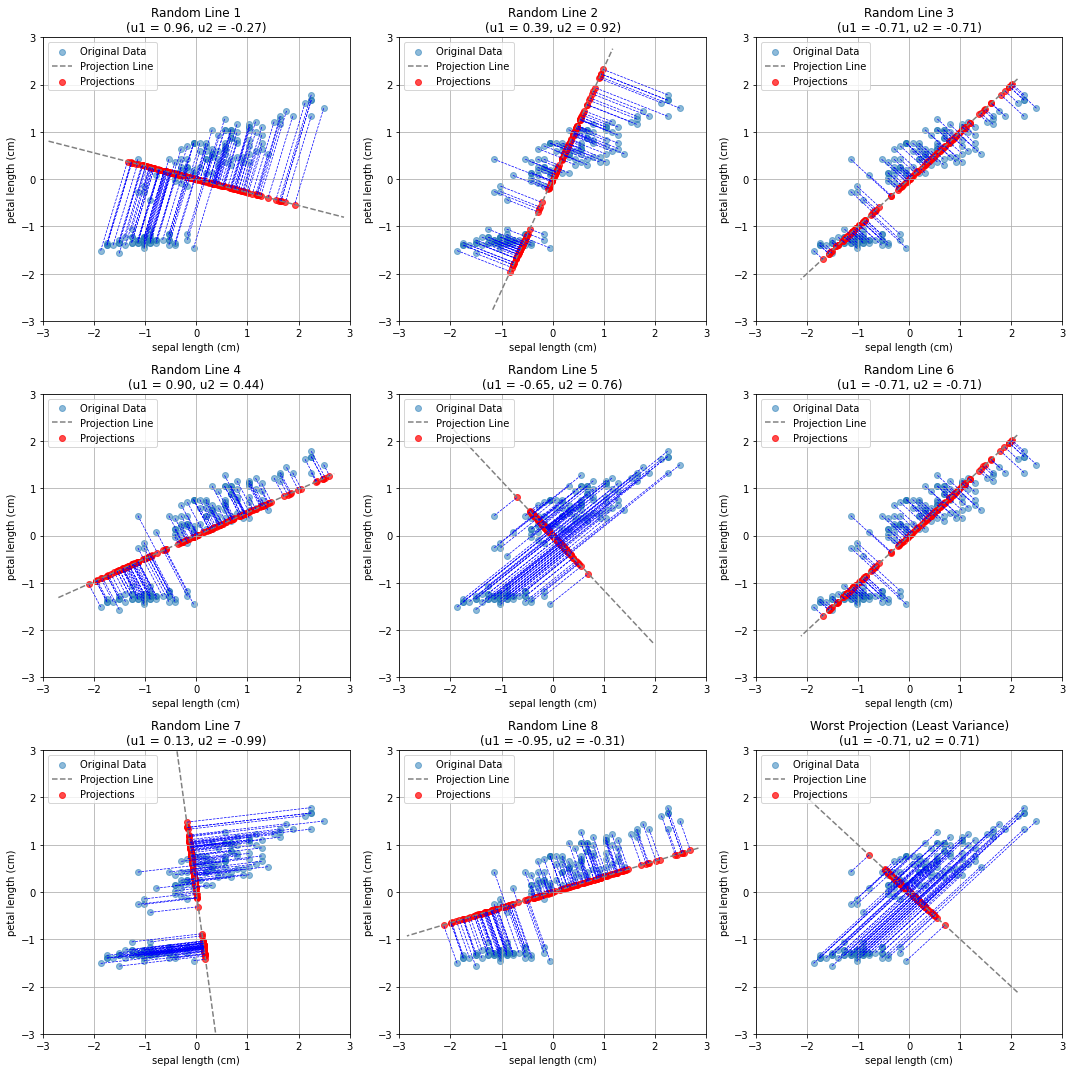

In [68]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Load and standardize the dataset
data = load_iris(as_frame=True)['data']
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

# Convert standardized data to a DataFrame
standardized_df = pd.DataFrame(standardized_data, columns=data.columns)

# Use only two features for 2D plotting
x_feature = 'sepal length (cm)'
y_feature = 'petal length (cm)'
X = standardized_df[[x_feature, y_feature]].values

# Generate random lines for projection
np.random.seed(42)  # For reproducibility
num_random_lines = 8
random_directions = [np.random.randn(2) for _ in range(num_random_lines)]
random_directions = [direction / np.linalg.norm(direction) for direction in random_directions]  # Normalize them

# Calculate the "worst" projection direction (minimum variance)
cov_matrix = np.cov(X.T)
eigvals, eigvecs = np.linalg.eig(cov_matrix)
worst_direction = eigvecs[:, np.argmin(eigvals)]  # Direction with the smallest eigenvalue
random_directions.append(worst_direction / np.linalg.norm(worst_direction))  # Add as the last projection

# Set consistent axis limits
x_limits = [-3, 3]
y_limits = [-3, 3]

# Plot the data and projections in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for idx, (direction, ax) in enumerate(zip(random_directions, axes.flatten())):
    # Calculate projections of the points on the random line
    projections = X @ direction.reshape(-1, 1)  # Dot product for projection
    projected_points = projections * direction  # Scale projections back to the 2D space

    # Plot original data points
    ax.scatter(X[:, 0], X[:, 1], label='Original Data', alpha=0.5)
    
    # Plot projection line
    line_x = np.array([-3, 3]) * direction[0]
    line_y = np.array([-3, 3]) * direction[1]
    ax.plot(line_x, line_y, color='gray', linestyle='--', label='Projection Line')
    
    # Plot projected points
    ax.scatter(projected_points[:, 0], projected_points[:, 1], color='red', alpha=0.7, label='Projections')
    
    # Draw dashed lines from each point to its projection
    for original, projected in zip(X, projected_points):
        ax.plot([original[0], projected[0]], [original[1], projected[1]], color='blue', linestyle='dashed', linewidth=0.7)

    # Set the same limits for each subplot
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    # Get the values of (u1, u2) for the title
    u1, u2 = direction[0], direction[1]
    
    # Determine the title for each subplot with vector values included
    if idx < num_random_lines:
        ax.set_title(f'Random Line {idx + 1}\n(u1 = {u1:.2f}, u2 = {u2:.2f})')
    else:
        ax.set_title(f'Worst Projection (Least Variance)\n(u1 = {u1:.2f}, u2 = {u2:.2f})')
    
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.legend(loc='upper left')
    ax.grid()

plt.tight_layout()
plt.show()


As can be seen, **not all projections are the same**. Indeed, some of them tend to project the points in a space in which they are very close to each other, while others allow for more "space" between the points.

Intuitively, we would like to project points in a way that **they keep their distinctiveness as much as possible**. We can reason on this also form the point of view of information loss. Let's say we want to reconstruct the values of $x_1$ and $y_1$ from $z$. Recall that the process by which we project $(x_1,x_2)$ onto $(u_1,u_2)$ is **lossy**:

$$z = u_1 x_1 + u_2 x_2$$

In practice, **we cannot reconstruct $x_1$ and $x_2$ with arbitrary precision**. The best we can do is to approximate the point with its projection, hence by scaling vector $(u_1,u_2)$ by $z$:

$$(\hat{x}_1,\hat{x}_2)^T = z \cdot (u_1,u_2)^T$$

An example is shown in the following figure:

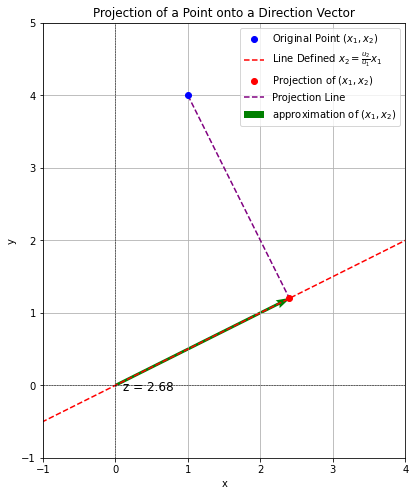

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Original point (x, y)
x = 1
y = 4
point = np.array([x, y])

# Direction vector u (normalized)
u = np.array([2, 1])
u = u / np.linalg.norm(u)  # Normalize the direction vector to make it a unit vector

# Projection of the point onto the direction vector u
z = np.dot(point, u)  # Calculate the scalar projection
projection = z * u  # Reconstructed point using z * u

# Create the plot
plt.figure(figsize=(8, 8))

# Plot the original point (x, y)
plt.scatter(point[0], point[1], color='blue', label='Original Point $(x_1, x_2)$', zorder=5)

# Plot the direction vector u
#plt.quiver(0, 0, u[0]*100, u[1]*100, angles='xy', scale_units='xy', scale=1, color='gray', linestyle='--', label='Line Defined by u')
plt.plot([-u[0]*100, u[0]*100], [-u[1]*100, u[1]*100],  color='red', linestyle='--', label='Line Defined $x_2=\\frac{u_2}{u_1}x_1$')

# Plot the projection of the point onto the line defined by u
plt.scatter(projection[0], projection[1], color='red', label='Projection of $(x_1, x_2)$', zorder=5)

# Draw the projection line (from original point to projection point)
plt.plot([point[0], projection[0]], [point[1], projection[1]], color='purple', linestyle='dashed', label='Projection Line')

# Plot the arrow from the origin to u with the text "z" showing the length of the vector
plt.quiver(0, 0, u[0], u[1], angles='xy', scale=z/1.45, color='green', width=0.008, label="approximation of $(x_1, x_2)$")
plt.text(u[0]/2, u[1]/2-0.25, f'z = {z:.2f}', color='black', ha='center', va='center', fontsize=12)

# Set axis limits and labels
plt.xlim(-1, 4)
plt.ylim(-1, 5)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Projection of a Point onto a Direction Vector')

# Display the legend
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()


In the expressions:

$$z = u_1 x_1 + u_2 x_2$$

$$(\hat{x}_1,\hat{x}_2)^T = z \cdot (u_1,u_2)^T$$

Points $(x_1,x_2)$ are the blue circles, while points $(\hat{x}_1,\hat{x}_2)$ are the red ones in the plots shown above on random projection. Intuitively, to reduce the reconstruction error, we want to choose **the line which best approximates the points**, hence reducing the distance between the points and the line (as in linear regression where we tried to minimize RSS).

**It can be shown that this is equivalent to finding the projection such that $z$ has the largest variance**. Intuitively, this makes sense as highest variance means that the points are more distinguishable and hence their reconstructions will be more distinguishable as well.

While we will not see it formally, the plot below shows replicates the previous plot adding the mean squared error between original and reconstructed points:

$$MSE = \frac{1}{N}\sum_{i}||({x}_1^{(i)},{x}_2^{(i)})-(\hat{x}_1^{(i)},\hat{x}_2^{(i)})||^2$$ 

Along with the variance of the projected data:

$$Var = \frac{1}{N}\sum_{i} (z^{(i)}-\overline{z})^2$$

where $\overline{z}=\frac{1}{N} \sum_{i} z^{(i)}$.


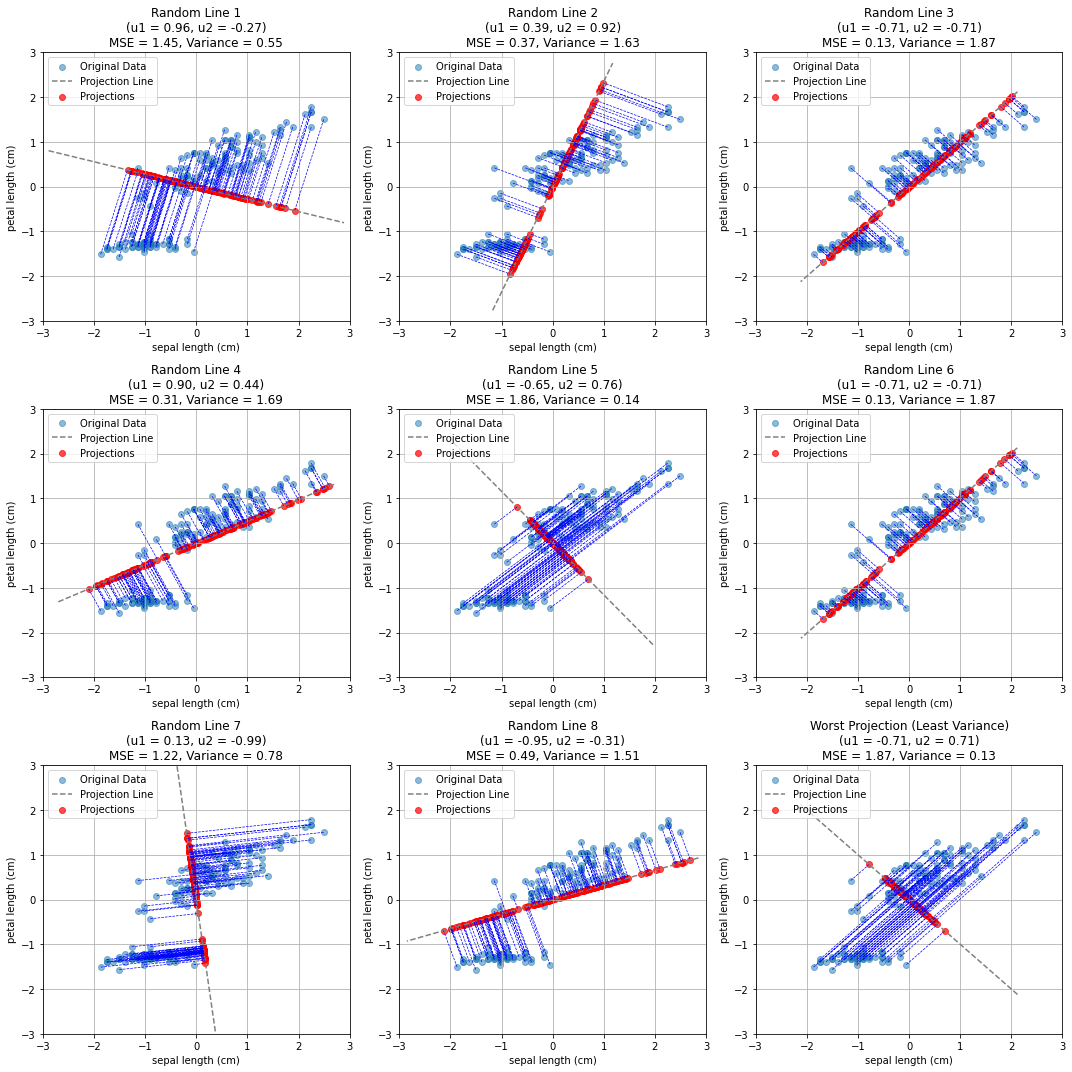

In [62]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import pandas as pd

# Load and standardize the dataset
data = load_iris(as_frame=True)['data']
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

# Convert standardized data to a DataFrame
standardized_df = pd.DataFrame(standardized_data, columns=data.columns)

# Use only two features for 2D plotting
x_feature = 'sepal length (cm)'
y_feature = 'petal length (cm)'
X = standardized_df[[x_feature, y_feature]].values

# Generate random lines for projection
np.random.seed(42)  # For reproducibility
num_random_lines = 8
random_directions = [np.random.randn(2) for _ in range(num_random_lines)]
random_directions = [direction / np.linalg.norm(direction) for direction in random_directions]  # Normalize them

# Calculate the "worst" projection direction (minimum variance)
cov_matrix = np.cov(X.T)
eigvals, eigvecs = np.linalg.eig(cov_matrix)
worst_direction = eigvecs[:, np.argmin(eigvals)]  # Direction with the smallest eigenvalue
random_directions.append(worst_direction / np.linalg.norm(worst_direction))  # Add as the last projection

# Set consistent axis limits
x_limits = [-3, 3]
y_limits = [-3, 3]

# Plot the data and projections in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for idx, (direction, ax) in enumerate(zip(random_directions, axes.flatten())):
    # Calculate projections of the points on the random line
    projections = X @ direction.reshape(-1, 1)  # Dot product for projection
    projected_points = projections * direction  # Scale projections back to the 2D space

    # Calculate MSE of the reconstruction error
    mse = np.mean(np.sum((X - projected_points) ** 2, axis=1))
    
    # Calculate variance of the projected data
    variance = np.var(projections)

    # Plot original data points
    ax.scatter(X[:, 0], X[:, 1], label='Original Data', alpha=0.5)
    
    # Plot projection line
    line_x = np.array([-3, 3]) * direction[0]
    line_y = np.array([-3, 3]) * direction[1]
    ax.plot(line_x, line_y, color='gray', linestyle='--', label='Projection Line')
    
    # Plot projected points
    ax.scatter(projected_points[:, 0], projected_points[:, 1], color='red', alpha=0.7, label='Projections')
    
    # Draw dashed lines from each point to its projection
    for original, projected in zip(X, projected_points):
        ax.plot([original[0], projected[0]], [original[1], projected[1]], color='blue', linestyle='dashed', linewidth=0.7)

    # Set the same limits for each subplot
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    # Get the values of (u1, u2) for the title
    u1, u2 = direction[0], direction[1]
    
    # Determine the title for each subplot with MSE and variance included
    if idx < num_random_lines:
        ax.set_title(f'Random Line {idx + 1}\n(u1 = {u1:.2f}, u2 = {u2:.2f})\nMSE = {mse:.2f}, Variance = {variance:.2f}')
    else:
        ax.set_title(f'Worst Projection (Least Variance)\n(u1 = {u1:.2f}, u2 = {u2:.2f})\nMSE = {mse:.2f}, Variance = {variance:.2f}')
    
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.legend(loc='upper left')
    ax.grid()

plt.tight_layout()
plt.show()


As can be noted, the MSE is smallest when the variance is highest, which corresponds to the condition in which the data is maximally distinguishable.

## General Formulation
We have seen a simple example in the case of two variables. Let us now discuss the general formulation in the case of $D$-dimensional variables.

Let $\{\mathbf{x}_n\}$ be a set of $N$ observations, where $n=1,\ldots,N$, and $\mathbf{x}_n$ is a vector of dimensionality $D$. We will define Principal Component Analysis as a projection of the data to $M \lt D$ dimensions such that the variance of the projected data is maximized.

> **NOTE**: to avoid any influence by the individual variances along the original axes, we will assume that **the data is standardized**.

We will first consider the case in which $M=1$. In this case, we want to find a D-dimensional vector $\mathbf{u}_1$ such that, projecting the data to this vector, variance is maximized. Without loss of generality, we will choose $\mathbf{u}_1$ such that $\mathbf{u}_1^T\mathbf{u}=1$. This corresponds to choosing $\mathbf{u}_1$ as a **unit vector**, which makes sense, as we are interested in the direction of the projection. We will find this assumption useful later.

Let $\overline{\mathbf{x}}$ be the sample mean:

$$\overline{\mathbf{x}} = \sum_{n=1}^N x_n$$

The data covariance matrix $\mathbf{S}$ will be:

$$\mathbf{S} = \frac{1}{N} \sum_{n=1}^N (\mathbf{x}_n - \overline{\mathbf{x}}) (\mathbf{x}_n - \overline{\mathbf{x}})^T$$

We know that projecting a data point to $\mathbf{u}_1$ is done simply by the dot product:

$$ \mathbf{u}_1^T \mathbf{x} $$

The mean of the projected data is hence $\mathbf{u}_1^T \overline{\mathbf{x}}$, and its variance is:

$$\frac{1}{N} \sum_{n=1}^N (\mathbf{u}_1^T \mathbf{x}_n - \mathbf{u}_1^T \overline{\mathbf{x}}) (\mathbf{u}_1^T \mathbf{x}_n - \mathbf{u}_1^T \overline{\mathbf{x}})^T = \mathbf{u}_1^T \frac{1}{N} \sum_{n=1}^N (\mathbf{x}_n -  \overline{\mathbf{x}}) ( \mathbf{x}_n - \overline{\mathbf{x}})^T \mathbf{u}_1 = \mathbf{u}_1^T \mathbf{S}\mathbf{u}_1 $$

To find an appropriate $\mathbf{u}_1$, we need to maximize the variance of the projected data with respect to $\mathbf{u}_1$. The optimization problem can be formalized as follows:

$$\arg\max \{\mathbf{u}_1^T\mathbf{S}\mathbf{u_1}\} \text{ subject to } \mathbf{u}_1^T\mathbf{u}_1=1$$

Note that the constraint $\mathbf{u}_1^T\mathbf{u}_1=1$ is necessary. Without it, we could arbitrarily increase the variance by choosing vectors $\mathbf{u}_1$ with large modules, hence $\mathbf{u}_1^T\mathbf{u}_1 \to +\infty$.

**We will not see how this optimization problem is solved in details**, but it can be shown that the variance is maximized when:

$$\mathbf{u}_1^T \mathbf{S} \mathbf{u}_1 = \lambda_1$$

Note that this is equivalent to:

$$\mathbf{S} \mathbf{u}_1 = \lambda_1 \mathbf{u}_1$$

From the result above, we find out that:
* The solution $\mathbf{u}_1$ is an eigenvector of $\mathbf{S}$. The related eigenvalue  $\lambda_1$ is the variance along that dimension;
* Since we want to maximize the variance, among all eigenvectors, we should choose the one with the **largest eigenvalue $\lambda_1$**.

The vector $\mathbf{u}_1$ will be **the first principal component** of the data.

**We can proceed in an iterative fashion to find the other components**. In practice, it can be shown that, to obtain uncorrelated variables, it is convenient to choose the next component $\mathbf{u}_2$ such that $\mathbf{u}_2 \perp \mathbf{u}_1$. Doing so, we will form an **orthonormal base** of the data. We can hence identify the second principal component by choosing the vector $\mathbf{u}_2$ with maximizes the variance **among all vectors which are orthogonal to $\mathbf{u}_1$**.

In practice, it can be shown that the $M$ principal components can be found by choosing the $M$ eigenvectors $\mathbf{u}_1, \ldots, \mathbf{u}_M$ of the covariance matrix $\mathbf{S}$ corresponding to the largest eigenvectors $\lambda_1, \ldots, \lambda_M$.

Let us define the matrix $W$ as follows:

$$\mathbf{W} = \left(\begin{matrix}
\mathbf{u}_1 \\
\mathbf{u}_2 \\
\ldots \\
\mathbf{u}_M \\
\end{matrix}\right) = \left(\begin{matrix}
u_{11} & u_{12} & \ldots & u_{1D} \\
u_{21} & u_{22} & \ldots & u_{2D} \\
\ldots \\
u_{M1} & u_{M2} & \ldots & u_{MD} \\
\end{matrix}\right)$$

where $u_{ij}$ is the $j^{th}$ component of vector $\mathbf{u}_i$.

Note that, given the way we constructed this matrix, it will be **a unit orthonormal matrix**. Indeed:
* All rows are perpendicular, hence the dot product of any row with any other will be $\mathbf{u}_i^T \mathbf{u}_j=1$;
* The scalar product of any row with itself will be: $\mathbf{u}_i^T \mathbf{u}_i$=1;
* As a consequence the two conditions above will be valid also for columns;
* The determinant of $\mathbf{W}$ will be 1.

If we choose $M=D$, we can hence see **$\mathbf{W}$ as a rotation matrix, coherently with our previous interpretation of the PCA**. If $M \lt D$, the matrix $\mathbf{W}$ identifies a **new base for the data**.

Let:

$$\mathbf{X} = \left(\begin{matrix}
\mathbf{x}_1 \\
\mathbf{x}_2 \\
\ldots \\
\mathbf{x}_N \\
\end{matrix}\right) = \left(\begin{matrix}
x_{11} & x_{12} & \ldots & x_{1D} \\
x_{21} & x_{22} & \ldots & x_{2D} \\
\ldots \\
x_{N1} & x_{N2} & \ldots & x_{ND} \\
\end{matrix}\right)$$

be the $[N \times D]$ data matrix.

We can project the data matrix $X$ to the principal components with the following formula:

$$\mathbf{Z} = \mathbf{X} \mathbf{W}^T$$

$\mathbf{Z}$ will be an $[N \times M]$ matrix in which the $i^{th}$ row denotes the $i^{th}$ element of the dataset projected to the PCA space.

In geometrical terms, the PCA **performs a rotation of the D-dimensional data around the center of the data** in a way that:
* The new axes are sorted by variance;
* The projected data is uncorrelated.

## Back to Our Example
We now have the computational tools to fully understand our example. Let us plot the data again. We will consider the mean-centered data:

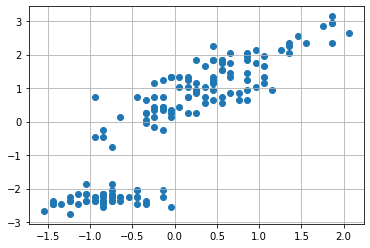

In [11]:
dat = np.vstack([h1,h2]).T
plt.scatter(x=h1, y=h2)
plt.grid()
plt.show()

We have seen that the covariance matrix plays a central role in PCA. The covariance matrix will be as follows in our case:

In [12]:
S = np.cov(dat.T)
S

array([[0.68569351, 1.27431544],
       [1.27431544, 3.11627785]])

The eigvenvalues and eigenvectors will be as follows:

In [13]:
from scipy.linalg import eig
eigenval, eigenvec = eig(S)
eigenval = np.real(eigenval)
eigenvec = eigenvec.T
print(f"Eigenvalues: {eigenval}\n")
print(f"Eigenvectors:\n {eigenvec}")

Eigenvalues: [0.1400726  3.66189877]

Eigenvectors:
 [[-0.9192793   0.39360585]
 [-0.39360585 -0.9192793 ]]


The rows of the eigenvector matrix identify two principal components. The first one is associated to a variance of about $0.14$ (the first eigvenvalue), while the second component is associated to a variance of $3.66$. Let us re-order the principal components so that eigenvalues are descending (we want the first principal component to have the largest value):

In [14]:
sort = np.argsort(eigenval)[::-1]
eigenval = eigenval[sort]
eigenvec = eigenvec[sort]

print(f"Eigenvalues: {eigenval}\n")
print(f"Eigenvectors:\n {eigenvec}")

Eigenvalues: [3.66189877 0.1400726 ]

Eigenvectors:
 [[-0.39360585 -0.9192793 ]
 [-0.9192793   0.39360585]]


The two components identify two directions along which we can project our data, as shown in the following plot:

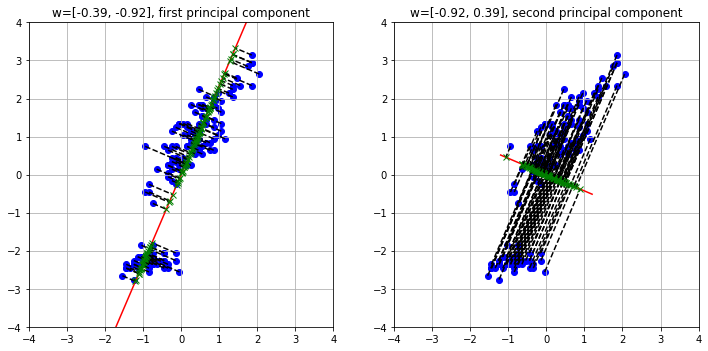

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_projection(points, vector, ax, angle):
    vector = vector.astype('float64')/np.linalg.norm(vector)

    xmax = points[:,0].max()*2
    xmin = points[:,0].min()*2
    ymax = points[:,1].max()*2
    ymin = points[:,1].min()*2


    # Plot the points
    ax.scatter(points[:,0], points[:,1], color='b')

    maxpoint = np.array([xmax,ymax])
    proj = np.dot(maxpoint,vector)/ np.linalg.norm(vector) ** 2 * vector

    ax.plot([0,proj[0]], [0, proj[1]],'-r')
    ax.plot([0,-proj[0]], [0, -proj[1]],'-r')

    for i in range(len(points)):
        projection = np.dot(points[i], vector) / np.linalg.norm(vector) ** 2 * vector
        # # Draw a line connecting the point to its projection
        ax.plot([points[i][0], projection[0]], [points[i][1], projection[1]], linestyle='--', color='k')
    
        ax.plot(projection[0],projection[1], color='g', marker='x')

    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.set_title(f"w=[{vector[0]:0.2f}, {vector[1]:0.2f}], {angle}")


dat = np.vstack([h1,h2]).T

axs = plt.subplots(1,2, figsize=(12,12))[1].ravel()
plot_projection(dat, eigenvec[0], axs[0], "first principal component")
plot_projection(dat, eigenvec[1], axs[1], "second principal component")
plt.show()


The eigenvectors can also be interpreted as vectors in the original space. Getting back to our 2D example, they would be shown as follows:

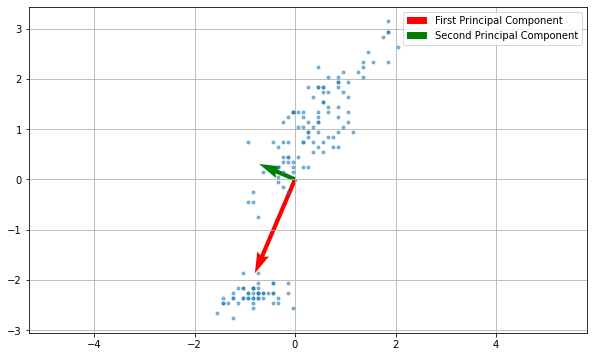

In [17]:
plt.figure(figsize=(10,6))
W = eigenvec
set2d = pd.DataFrame({'x': h1, 'y':h2})
#specifico alpha=0.5 per visualizzare i punti in trasparenza
plt.plot(set2d.x,set2d.y,'.',alpha=0.5)
#uso la funzione quiver per plottere i vettori
plt.quiver(set2d.x.mean(),set2d.y.mean(),W[0,0],W[1,0], scale=20/eigenval[0], color='red', label='First Principal Component')
plt.quiver(set2d.x.mean(),set2d.y.mean(),W[0,1],W[1,1], scale=2/eigenval[1], color='green', label='Second Principal Component')
#impongo che gli assi abbiano la stessa scala
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

The two principal components denote the **main directions of variation within the data**. In the plot above, the vector sizes are proportional to the related eigenvalues (hence the variance).

As we can see, the two directions are orthogonal. We can also project the data maintaining the original dimensionality with:

$$\mathbf{Z} = \mathbf{X}\mathbf{W}^T$$

This process can also see as rotating the data in a way that the the first principal component becomes the new $x$ axis, while the second principal component becomes the $y$ axis. In this context, $\mathbf{W}$ can be seen as a **rotation matrix**. The plot below compares the original and rotated data:

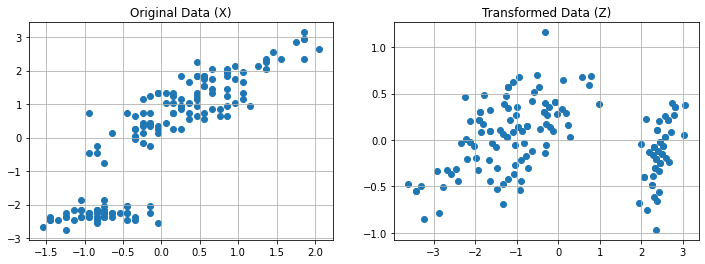

In [ ]:
dat = np.vstack([h1,h2]).T
dat2 = np.matmul(dat,eigenvec.T)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(x=dat[:,0], y=dat[:,1])
plt.title("Original Data (X)")
plt.grid()
plt.subplot(122)
plt.scatter(x=dat2[:,0], y=dat2[:,1])
plt.title("Transformed Data (Z)")
plt.grid()
plt.show()

We can see the projection to the first principal component in two stages:
1. Rotating the data;
2. Dropping the $y$ axis.

Note that the same reasoning can be seen in 3D as shown in the following example:

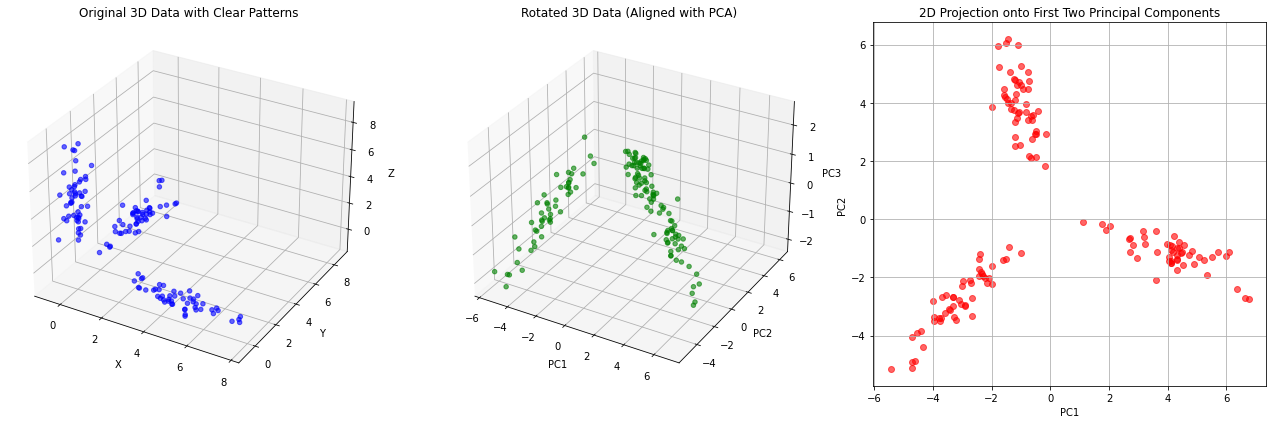

In [ ]:
# Generate 3D data with more distinct patterns
np.random.seed(42)

# Create data clusters with clear elongation along specific axes
cluster1 = np.random.multivariate_normal([5, 0, 0], [[3, 0, 0], [0, 0.1, 0], [0, 0, 0.1]], 50)
cluster2 = np.random.multivariate_normal([0, 5, 0], [[0.1, 0, 0], [0, 3, 0], [0, 0, 0.1]], 50)
cluster3 = np.random.multivariate_normal([0, 0, 5], [[0.1, 0, 0], [0, 0.1, 0], [0, 0, 3]], 50)

# Combine the clusters into one dataset
data_3d_distinct = np.vstack([cluster1, cluster2, cluster3])

# Apply PCA to the more distinct 3D data
pca.fit(data_3d_distinct)
data_rotated_distinct = pca.transform(data_3d_distinct)
data_projected_2d_distinct = data_rotated_distinct[:, :2]

# Create the figure with 3 subplots
fig = plt.figure(figsize=(18, 6))

# Plot 1: Original 3D data with clear patterns
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(data_3d_distinct[:, 0], data_3d_distinct[:, 1], data_3d_distinct[:, 2], c='blue', alpha=0.6)
ax1.set_title('Original 3D Data with Clear Patterns')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Plot 2: 3D data after PCA rotation
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(data_rotated_distinct[:, 0], data_rotated_distinct[:, 1], data_rotated_distinct[:, 2], c='green', alpha=0.6)
ax2.set_title('Rotated 3D Data (Aligned with PCA)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')

# Plot 3: 2D projection of the more distinct 3D data
ax3 = fig.add_subplot(133)
ax3.scatter(data_projected_2d_distinct[:, 0], data_projected_2d_distinct[:, 1], c='red', alpha=0.6)
ax3.set_title('2D Projection onto First Two Principal Components')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.grid(True)

plt.tight_layout()
plt.show()


## PCA for data whitening
It can also be seen that PCA transforms the original data with a given covariance matrix $\Sigma$ to a new set of data (with new axes, the principal components), such that its covariance matrix $\Sigma'$ is **the identity matrix**. This means that **the new variables** are now **decorrelated**.

Intuitively, this makes sense: **we rotated the data so that the new axes are aligned to main directions of variation and we constructed principal components to be orthogonal to each other**.

This process is also called **whitening transformation**. An example of this property is shown below:

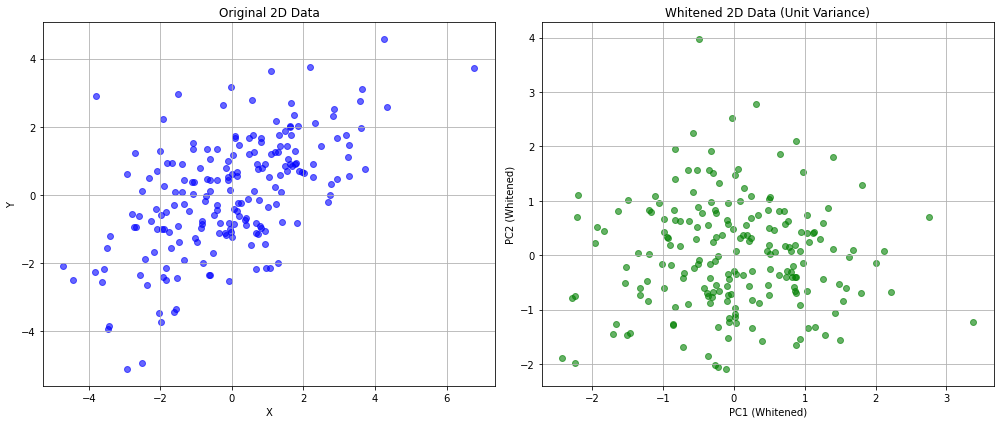

(array([[3.60543087, 1.84308349],
        [1.84308349, 2.83596216]]),
 array([[1.00000000e+00, 1.71554563e-17],
        [1.71554563e-17, 1.00000000e+00]]))

In [58]:
# Generate 2D data with correlation
np.random.seed(42)
mean_2d = [0, 0]
cov_2d = [[4, 2], [2, 3]]  # Covariance matrix to induce correlation
data_2d = np.random.multivariate_normal(mean_2d, cov_2d, 200)

# Calculate covariance matrix of the original data
original_cov_matrix = np.cov(data_2d, rowvar=False)

# Apply PCA with whitening
pca_whitening = PCA(n_components=2, whiten=True)
data_whitened = pca_whitening.fit_transform(data_2d)

# Calculate covariance matrix of the whitened data
whitened_cov_matrix = np.cov(data_whitened, rowvar=False)

# Plot the original data and whitened data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Original 2D data with correlation
axes[0].scatter(data_2d[:, 0], data_2d[:, 1], c='blue', alpha=0.6)
axes[0].set_title('Original 2D Data')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True)

# Plot 2: Whitened 2D data
axes[1].scatter(data_whitened[:, 0], data_whitened[:, 1], c='green', alpha=0.6)
axes[1].set_title('Whitened 2D Data (Unit Variance)')
axes[1].set_xlabel('PC1 (Whitened)')
axes[1].set_ylabel('PC2 (Whitened)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Display the covariance matrices before and after whitening
original_cov_matrix, whitened_cov_matrix


This whitening process can be useful when we need to make sure that the input variables are **decorrelated**. For instance, consider the case in which we need to fit a linear regression but we have multiple correlated variables. Pre-processing data with PCA would make sure that the input variables are decorrelated, hence removing any instability during fitting, but it should be also kept in mind that **the linear regression would become less interpretable because of the PCA transformation**.

## Choosing an Appropriate Number of Components

We have seen how PCA allows to reduce the dimensionality of the data. In short, this can be done by computing the first $M$ eigenvalues and the associated eigenvectors.

In some cases, it is clear what is the value of $M$ we need to set. For example, in the case of sorting Fisher's Iris, we set $M=1$ because we needed a scalar number. In other cases, we would like to reduce the dimensionality of the data, **while keeping a reasonable amount of information about the original data**.

We have seen that the variance is related to the MSE reprojection error and hence to the informative content. We can measure **how much information we are retaining by selecting $M$ components by measuring the cumulative variance of the first M components**. 

We will now consider as an example the whole Fisher Iris dataset, which has four features. The four Principal Components will be as follows:

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(data.values)
comp = pca.components_
cols = data.columns
pd.DataFrame({
    cols[0] : comp[0],
    cols[1] : comp[1],
    cols[2] : comp[2],
    cols[3] : comp[3],
    'components' : "z1 z2 z3 z4".split(' ')
}).set_index('components')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
components,,,,
z1,0.361387,0.656589,-0.582030,-0.315487
z2,-0.084523,0.730161,0.597911,0.319723
z3,0.856671,-0.173373,0.076236,0.479839
z4,0.358289,-0.075481,0.545831,-0.753657


The covariance matrix of the transformed data will be as follows:

In [19]:
dd = pca.transform(data.values)
df = pd.DataFrame({
    f"z{i+1}":dd[:,i] for i in range(4)
}).cov().style.format('{:.2f}')
df

,z1,z2,z3,z4
z1,4.23,0.00,-0.00,0.00
z2,0.00,0.24,-0.00,-0.00
z3,-0.00,-0.00,0.08,0.00
z4,0.00,-0.00,0.00,0.02


As we could expect, the covariance matrix is diagonal because the new features are decorrelated. We also note that the principal components are sorted by variance. We will define the variance of the data along the $z_i$ component as:

$$var(z_i)$$

The total variance is given by the sum of the variances:

$$V = var(z_1) + var(z_2) + \ldots + var(z_D)$$

More in general, we will define:

$$V(n) = var(z_1) + var(z_2) + \ldots + var(z_n)$$

Hence $V=V(D)$.

In our example, the total variance $V$ will be:

In [20]:
total_variance = np.diag(pd.DataFrame({
    f"z{i+1}":dd[:,i] for i in range(4)
}).cov().values).sum()
print(f"{total_variance:0.2f}")

4.57


We can quantify the fraction of variance explained by each component $n$ as follows:

$$\frac{var(n)}{V(N)}$$

If we compute such value for all $n$, we obtain the following vector in our example:

In [22]:
vals =np.diag(pd.DataFrame({
    f"z{i+1}":dd[:,i] for i in range(4)
}).cov().values)/total_variance
vals

array([0.92461872, 0.05306648, 0.01710261, 0.00521218])

In practice, it is common to visualize the explained variance ratio in a **scree plot**:

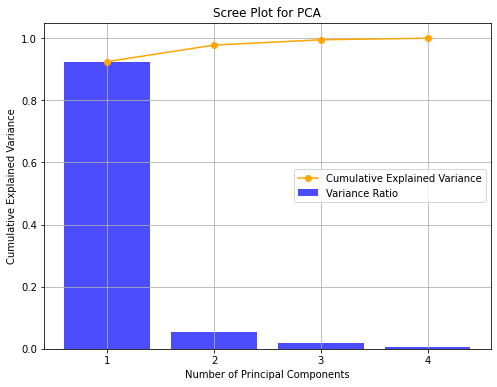

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# Load iris dataset as an example
iris = load_iris()
X = iris.data

# Apply PCA
pca = PCA()
pca.fit(X)

# Get explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot scree plot with both bar plot for variance and line plot for cumulative explained variance
plt.figure(figsize=(8, 6))

# Bar plot for explained variance ratio
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color='blue', alpha=0.7, label='Variance Ratio')
plt.title('Scree Plot for PCA')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))

# Line plot for cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='orange', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

# Show legend
plt.legend()
plt.grid()
plt.show()


As we can see, the first component retains $92.46\%$ of the variance, while the second one retains only $5.3\%$ of the variance. It is common to also look at the cumulative variance ratio, defined as:

$$\frac{V(n)}{V(N)}$$

In our case:

In [498]:
(np.diag(pd.DataFrame({
    f"z{i+1}":dd[:,i] for i in range(4)
}).cov().values)/total_variance).cumsum()

array([0.92461872, 0.97768521, 0.99478782, 1.        ])

The vector above tell us that considering the first two components accounts for about $97.77\%$ of the variance.

This approach can guide us in choosing the right number of dimensions to keep, selecting a budget of the variance we wish to be able to retain.

## Interpretation of the Principal Components - Load Plots
When we transform data with PCA, the new variables have a less direct interpretation. Indeed, if a given variable is a linear combination of other variables, it is not straightforward to assign a meaning to each component.

However, we know that the first components are the ones which contain most of the variance. Hence, inspecting the weights that each of these components given to the original features can give some insights into which of the original features are more relevant. In this context, **the weights of the principal components are also called loadings**. Loadings with **large absolute values are more influential in determining the value of the principal components**.

In practice, we can assess the relevance of features with a **load plot**, which represents each original variable as a 2D point of coordinates given by the loadings corresponding to the first two principal components. Let us show the load plot for our example:

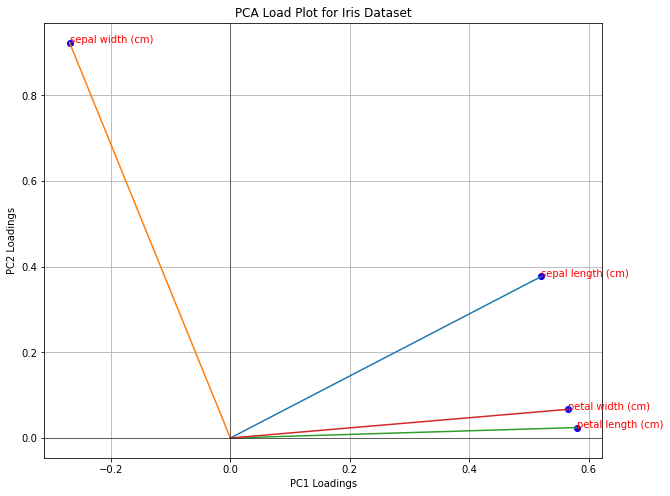

In [503]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Standardize the features (important for PCA)
scaler = StandardScaler()
iris_std = scaler.fit_transform(iris_df)

# Perform PCA
pca = PCA()
pca.fit(iris_std)

# Access the loadings (coefficients)
loadings = pca.components_

# Create a load plot
plt.figure(figsize=(10, 8))

# Plot loadings for the first two principal components
plt.scatter(loadings[0, :], loadings[1, :], marker='o', color='blue')

# Annotate each point with the variable names
for i, var_name in enumerate(iris_df.columns):
    plt.annotate(var_name, (loadings[0, i], loadings[1, i]), color='red')
    plt.plot([0,loadings[0,i]], [0, loadings[1,i]])

# Add labels and title
plt.xlabel('PC1 Loadings')
plt.ylabel('PC2 Loadings')
plt.title('PCA Load Plot for Iris Dataset')

# Add grid lines for reference
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid()

# Show the plot
plt.show()


In a load plot: 
* variables that cluster together are positively correlated, while variables on opposite sides may be negatively correlated;
* variables which are further from the origin have higher loadings, so they are more influential in the computation of the PCA.

A loading plot can also be useful to perform feature selection. For instance, from the plot above all variables seem to be influential, but `petal width` and `petal length` are correlated. We could think of using as a subset of variables `sepal width`, `sepal length` and one of the other two (e.g., `petal length`).

## Applications of PCA
PCA has several applications in data analysis. We will summarize the main ones in the following.

### Dimensionality Reduction and Visualization

We have seen that data can be interpreted as a set of D-dimensional points. When $D=2$, it is often useful to visualize the data through a scatterplot. This allows us to see how the data distributes in the space. When $D>2$, we can show a series a scatterplot (a pairplot or scattermatrix). However, when $D$ is very large, it is usually unfeasible to visualize data with all possible scatterplots.

In these cases, it can be useful to transform the data with PCA and then visualize the data points as 2D points in the space identified by the first two principal components. 

We will show an example on the multidimensional dataset **DIGITS**. The dataset contains small images of resolution $8 \times 8 pixels$ representing handwritten digits from $0$ to $9$. We can see the dataset as containing $64$ variables. Each variable indicates the pixel value at a specific location.


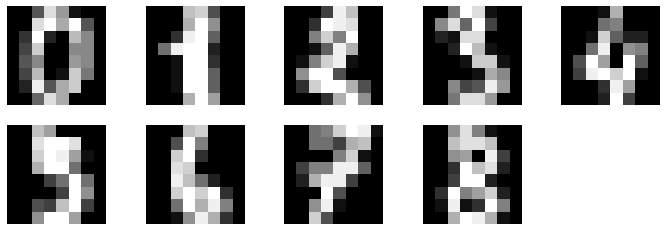

In [514]:
from sklearn.datasets import load_digits
digits=load_digits()

plt.figure(figsize=(12,4))
for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(digits.data[i].reshape((8,8)),cmap='gray')
    plt.axis('off')
plt.show()

We can visualize the data with PCA by first projecting the data to $M=2$ principal components, then plotting the transformed data as 2D points.

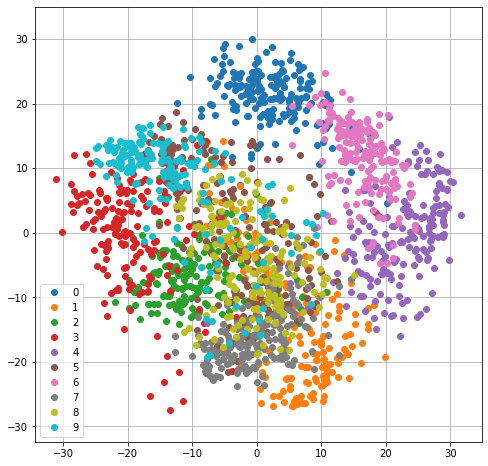

In [517]:
pca=PCA(n_components=2)
pca.fit(digits.data)
Y=pca.transform(digits.data)

plt.figure(figsize=(8,8))
legend = []
for c in np.unique(digits.target):
    plt.plot(Y[digits.target==c,0],Y[digits.target==c,1],'o')
    legend.append(c)

plt.legend(legend)
plt.grid()
plt.axis('equal')
plt.show()

### Data Decorrelation - Principal Component Regression
PCA is also useful when we need to fit a linear regressor and we are in the presence of a dataset with multi-collinearity.

Let us consider the `auto_mpg` dataset:

In [34]:
from scipy.stats import zscore
from ucimlrepo import fetch_ucirepo 
from statsmodels.formula.api import ols
import pandas as pd
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9)
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
data = X.join(y)
data

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0
...,...,...,...,...,...,...,...,...
393,140.0,4,86.0,2790,15.6,82,1,27.0
394,97.0,4,52.0,2130,24.6,82,2,44.0
395,135.0,4,84.0,2295,11.6,82,1,32.0
396,120.0,4,79.0,2625,18.6,82,1,28.0


If we try to fit a linear regressor with all variables, we will find multicollinearity:

In [35]:
from statsmodels.formula.api import ols
ols("mpg ~ displacement + cylinders + horsepower + weight + acceleration + model_year + origin", data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-17.2184,4.644,-3.707,0.000,-26.350,-8.087
displacement,0.0199,0.008,2.647,0.008,0.005,0.035
cylinders,-0.4934,0.323,-1.526,0.128,-1.129,0.142
horsepower,-0.0170,0.014,-1.230,0.220,-0.044,0.010
weight,-0.0065,0.001,-9.929,0.000,-0.008,-0.005
acceleration,0.0806,0.099,0.815,0.415,-0.114,0.275
model_year,0.7508,0.051,14.729,0.000,0.651,0.851
origin,1.4261,0.278,5.127,0.000,0.879,1.973


Indeed, some variables have a large p-value, probably because they are correlated with the others.

To perform Principal Component Regression, we can first compute PCA **on the independent variables**, then fit a linear regressor. We will choose $M=4$ principal components:

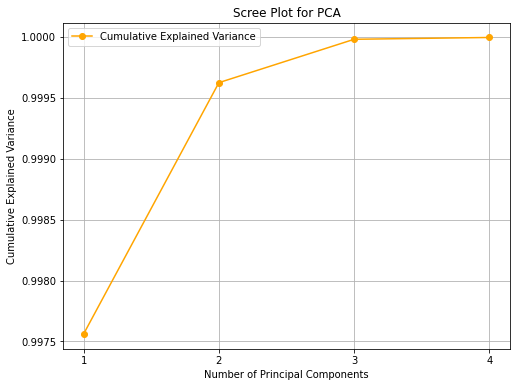

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     92.20
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           9.24e-55
Time:                        21:38:13   Log-Likelihood:                -1207.7
No. Observations:                 386   AIC:                             2425.
Df Residuals:                     381   BIC:                             2445.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.3607      0.283     82.480      0.000      22.804      23.918
z1            -0.0051      0.000    -15.346      0.000      -0.006      -0.004
z2            -0.0320      0.007     -4.373      0.000      -0.046      -0.018
z3            -0.0552      0.018     -3.138      0.002      -0.090      -0.021
z4            -0.8815      0.086    -10.234      0.000      -1.051      -0.712
==============================================================================
Omnibus:                        3.702   Durbin-Watson:                   1.125
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.435
Skew:                           0.214   Prob(JB):                        0.179
Kurtosis:                       3.174   Cond. No.                         860.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
pca = PCA(n_components=4)
dd = data.dropna()
pca.fit(dd.drop('mpg', axis=1))
zz = pca.transform(dd.drop('mpg', axis=1))

data2 = pd.DataFrame({
    f"z{i+1}": zz[:,i]
    for i in range(zz.shape[1])
})

data2=data2.join(dd['mpg'])

#print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())

# Get explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot scree plot with both bar plot for variance and line plot for cumulative explained variance
plt.figure(figsize=(8, 6))

# Bar plot for explained variance ratio
plt.title('Scree Plot for PCA')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))

# Line plot for cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='orange', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

# Show legend
plt.legend()
plt.grid()
plt.show()

ols("mpg ~ z1 + z2 + z3 + z4", data2).fit().summary()


While the result is not as interpretable as it was before, this technique may be useful in the case of predictive analysis.

### Data Compression

Now let's see a simple example of data compression using PCA. In particular, we will consider the case of compressing images. An image can be seen as high-dimensional data, where the number of dimensions is equal to the number of pixels. For example, an RGB image of size $640 \times 480$ pixels has $3 \cdot 640 \cdot 480=921600$ dimensions. 

We expect that there will be redundant information in all these dimensions. One method to compress images is to divide them into fixed-size blocks (e.g., $8 \times 8$). Each of these blocks will be an element belonging to a population (the population of $8 \times 8$ blocks of the image). 

Assuming that the information in the blocks is highly correlated, we can try to compress it by applying PCA to the sample of blocks extracted from our image and choosing only a few principal components to represent the content of the blocks.

We will consider the following example image:

Image Size: (427, 640, 3)
Number of dimensions: 819840


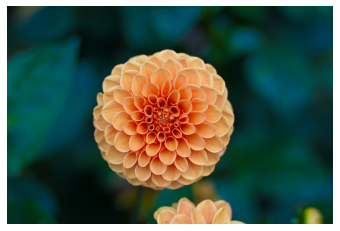

In [44]:
from sklearn.datasets import load_sample_image
flower = load_sample_image('flower.jpg')
print("Image Size:",flower.shape)
print("Number of dimensions:",np.prod(flower.shape))
plt.imshow(flower)
plt.axis('off')
plt.show()


We will divide the image into RGB blocks of size $8 \times 8 \times 3$ (these are $8 \times 8$ RGB images). These will look as follows:

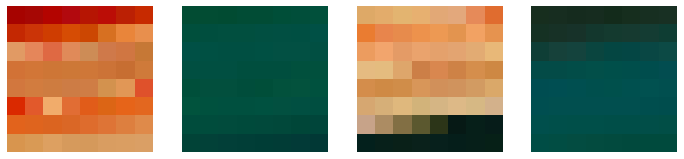

In [45]:
tiles = np.split(flower.ravel(),4270)
tiles=np.stack(tiles)
tiles.shape

plt.figure(figsize=(12,8))
plt.subplot(141)
plt.imshow(tiles[1855].reshape(8,8,3))
plt.axis('off')
plt.subplot(142)
plt.imshow(tiles[2900].reshape(8,8,3))
plt.axis('off')
plt.subplot(143)
plt.imshow(tiles[1856].reshape(8,8,3))
plt.axis('off')
plt.subplot(144)
plt.imshow(tiles[960].reshape(8,8,3))
plt.axis('off')
plt.show()

If we compute the PCA of all blocks, we will obtain the following cumulative variance ratio vector:

In [49]:
pca=PCA()
pca.fit(tiles)
np.cumsum(pca.explained_variance_ratio_)[:32]

array([0.72033322, 0.8054948 , 0.88473857, 0.91106289, 0.92773705,
       0.94002709, 0.94742984, 0.95262262, 0.95724086, 0.96138203,
       0.96493482, 0.96813026, 0.97074765, 0.97304417, 0.97502487,
       0.97676849, 0.97827393, 0.97961611, 0.98080084, 0.98195037,
       0.98298693, 0.98399279, 0.98491245, 0.98570784, 0.98649079,
       0.98719466, 0.98779928, 0.98835152, 0.98888528, 0.98937606,
       0.98983658, 0.99027875])

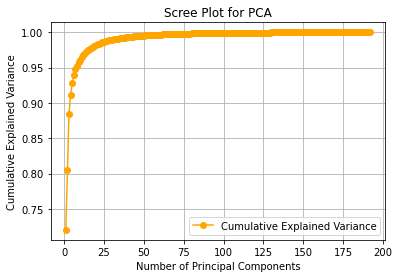

In [53]:
# Bar plot for explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()
plt.title('Scree Plot for PCA')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
#plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))

# Line plot for cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='orange', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

# Show legend
plt.legend()
plt.grid()
plt.show()

As we can see, truncating at the first component allows us to retain about $72%$ of the information, truncating at the second allows us to retain about $80%$, and so on, up to $32$ components, which allow us to retain about $99%$ of the information. Now let's see how to compress and reconstruct the image. We will choose the first $32$ components, preserving $99%$ of the information. 

If we do so, and then project the tiles to the compressed space each tile will be represented by only $32$ numbers. This will lead to the following savings in space:

In [562]:
pca = PCA(n_components=32)
pca.fit(tiles)
compressed_tiles = pca.transform(tiles)
compressed_tiles.shape

print("Space saved in the compression: {:0.2f}%".format(100-100*compressed_tiles.size/tiles.size))

Space saved in the compression: 83.33%


We can reconstruct the original image by applying the inverse PCA transformation to the compressed patches. The result will be as follows:

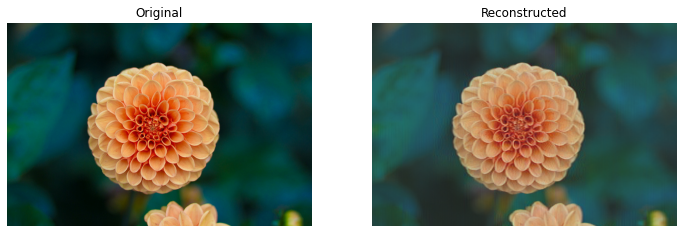

In [565]:
reconstructed_tiles = pca.inverse_transform(compressed_tiles)
reconstructed_tiles.shape

reconstructed_tiles = (reconstructed_tiles-reconstructed_tiles.min())\
            /(reconstructed_tiles.max()-reconstructed_tiles.min())*255
reconstructed_tiles=reconstructed_tiles.astype('uint8')

reconstructed_flower=reconstructed_tiles.ravel().reshape(flower.shape)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(flower)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Reconstructed')
plt.imshow(reconstructed_flower)
plt.axis('off')
plt.show()

The plot below shows how the reconstruction quality increases when more components are used:

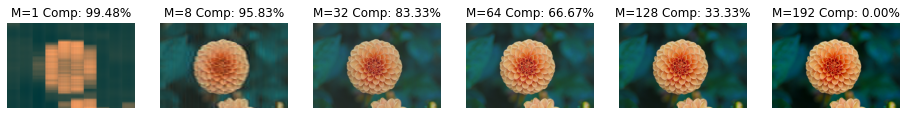

In [578]:
def compress(n_components):
    pca = PCA(n_components=n_components)
    pca.fit(tiles)
    compressed_tiles = pca.transform(tiles)
    compressed_tiles.shape

    saved_sapce = 100-100*compressed_tiles.size/tiles.size

    reconstructed_tiles = pca.inverse_transform(compressed_tiles)
    reconstructed_tiles.shape

    reconstructed_tiles = (reconstructed_tiles-reconstructed_tiles.min())\
                /(reconstructed_tiles.max()-reconstructed_tiles.min())*255
    reconstructed_tiles=reconstructed_tiles.astype('uint8')

    reconstructed_flower=reconstructed_tiles.ravel().reshape(flower.shape)

    return reconstructed_flower, saved_sapce

plt.figure(figsize=(16,4))
for i,c in enumerate([1,8,32,64,128,192]):
    plt.subplot(1,6,i+1)
    reconstructed, saved_space = compress(c)
    plt.imshow(reconstructed)
    plt.axis('off')
    plt.title(f"M={c} Comp: {saved_space:0.2f}%")

## References

- Parts of Chapter 12 of \[1\]

\[1\] Bishop, Christopher M., and Nasser M. Nasrabadi. Pattern recognition and machine learning. Vol. 4. No. 4. New York: springer, 2006.